# Experiment 1.4
Carrying on from experiment 1.3. We will repeat the idea of 1.3, but chop off the output side of the network to expose the pre-pooled activations. This is a process of increasing the resolution that we are investigating.

First, let's double check the model summary.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data
import torchinfo
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os
import torch.hub

In [2]:
model_ft = tv.models.resnet18(pretrained=True)

In [3]:
torchinfo.summary(model_ft, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [4]:
import IPython
def imshow(img):
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [5]:
GRID_SHAPE = (7, 7)
NUM_CELLS = np.prod(GRID_SHAPE)
IMG_SHAPE = (224, 224, 3)
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, (28, 28))
# Need to choose a diameter less than cell width/height
# Let's go with 20 (so radius is 10)
RADIUS = 10

In [6]:
def demo_data():
    FPS = 2
    frames, labels = nc.data.create_samples(30, radius=RADIUS, grid_shape=GRID_SHAPE, 
                                            img_shape=IMG_SHAPE)
    frames = [f*255 for f in frames]
    x_clip = mpe.ImageSequenceClip(frames, fps=2)
    y_clip = mpe.TextClip('WB-0', font='DejaVu-Sans')

    class FrameText(mpe.VideoClip):
        def __init__(self, text, fps):
            def make_frame(f):
               return mpe.TextClip(text[int(f)], font='DejaVu-Sans', color='white').get_frame(f)
            self.duration = 1.0 * len(text) / fps
            mpe.VideoClip.__init__(self, make_frame=make_frame, duration=self.duration)

    y_clip =   FrameText(labels, FPS)
    label_clip = mpe.CompositeVideoClip([mpe.ImageClip(np.zeros(nc.data.DEFAULT_IMG_SHAPE), duration=5), y_clip])
    comp_clip = mpe.clips_array([[y_clip],[x_clip]])
    return comp_clip
clip = demo_data() 
clip.ipython_display()

t:  13%|█▎        | 4/30 [00:00<00:00, 31.40it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


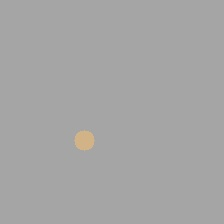

ic| sample['label']: 0
ic| sample['label_grid']: array([[3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 0, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3]])


In [7]:
def test_dataset():
    train, test, val = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered, 
                                      RADIUS, GRID_SHAPE, IMG_SHAPE)
    sample = val[1]
    imshow(sample['image'])
    ic(sample['label'])
    ic(sample['label_grid'])
test_dataset()

In [8]:
a = np.array([[0,1, 2],[3,4,5],[6,7,8]])
ic(a)
co = np.array([0, 1])
a[tuple(co)]

ic| a: array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8]])


1

## Customize the model
We want to have a model with the fully connected layer removed, and for that, it seems easiest to subclass and override.

In [9]:
class PoolHeadResNet(tv.models.ResNet):
    def __init__(self, train_all_params=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_classes = nc.data.NUM_CLASSES
        # First, disable all other parameters.
        if not train_all_params:
            for param in self.parameters():
                param.requires_grad = False
        # A 1x1 convolution, representing effectively a fully connected, sub-batched at 7x7.
        self.fc2 = torch.nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1,stride=1)
        
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Stop above.
        #x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)
        x = self.fc2(x)
        return x
    
train_all_params = True
model18 = PoolHeadResNet(train_all_params, tv.models.resnet.BasicBlock, [2, 2, 2, 2])
state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls['resnet18'])
model18.load_state_dict(state, strict=False)

_IncompatibleKeys(missing_keys=['fc2.weight', 'fc2.bias'], unexpected_keys=[])

### Modified model summary

In [10]:
torchinfo.summary(model18, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
PoolHeadResNet                           --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### Check that initialization of the new layer

In [11]:
model18.fc2.weight[0][0:10]

tensor([[[-0.0155]],

        [[ 0.0001]],

        [[-0.0345]],

        [[ 0.0014]],

        [[ 0.0037]],

        [[-0.0317]],

        [[ 0.0022]],

        [[ 0.0246]],

        [[-0.0275]],

        [[ 0.0251]]], device='cuda:0', grad_fn=<SliceBackward>)

All looks good! Now design the loss function.

### Find the correct loss function
The fundamental loss function is still the same (MLE loss); however, each forward pass now involves 7x7=49 different results that form a sort of "sub-batch". We need to modify the standard loss function to work with this increased output dimension.

First, test out an example loss. The `CrossEntropyLoss` function luckily supports multidimensional input/outputs in the way I need.

In [12]:
# Tesing out a loss function
# 4x2x2 (smaller test version of our 7x7x4).
fc_in = torch.tensor([# batch
    [ # 4x2x2
        [[-0.3, 0.0], [0.3, 3.2] ], # 2x2
        [[ 4.0, 0.1], [-4., 1.1] ], # 2x2
        [[ 7.0, 0.4], [2.0, -.4] ], # 2x2
        [[ 2.1, 4.1], [2.2, 4.1] ], # 2x2
    ]
], dtype=torch.float)
target = torch.tensor([ # batch
    [[0, 1], [1, 1]] # 2x2
], dtype=torch.long)
loss = torch.nn.CrossEntropyLoss(reduction='mean') # mean or sum for reduction
output = loss(fc_in, target)
ic(output)

ic| output: tensor(5.4190)


tensor(5.4190)

## Training
Let's fine tune a Resnet model.

In [15]:
# Copied from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
train_ds, test_ds, val_ds = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                        dot_radius=RADIUS,
                                                        grid_shape=(7,7))
train_ds.transform = data_transform
val_ds.transform = data_transform
#test_ds.transform = data_transform
ds = {'train': train_ds, 'val': val_ds, 'test': test_ds}
dataloaders = {x: torch.utils.data.DataLoader(ds[x], batch_size=4, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(ds[x]) for x in ['train', 'val']}

#device = (torch.device("cuda:0") if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")
#device = "cpu"

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)
                label_grids = batch['label_grid'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, label_grids)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == label_grids.data)
            if phase == 'train':
                scheduler.step()

            denom = dataset_sizes[phase] * NUM_CELLS
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # temporarily disable due to yet-unresearched error.
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# Load & train
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model = model18.to(device)

criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0293 Acc: 0.2978
val Loss: 0.0267 Acc: 0.4139

Epoch 1/4
----------
train Loss: 0.0293 Acc: 0.2978
val Loss: 0.0267 Acc: 0.4139

Epoch 2/4
----------
train Loss: 0.0293 Acc: 0.2978
val Loss: 0.0267 Acc: 0.4139

Epoch 3/4
----------
train Loss: 0.0293 Acc: 0.2978
val Loss: 0.0267 Acc: 0.4139

Epoch 4/4
----------
train Loss: 0.0293 Acc: 0.2978
val Loss: 0.0267 Acc: 0.4139

Training complete in 1m 58s
Best val Acc: 0.413855


## Results
After 20 epochs, we have 63% accuracy. This is _quite_ low, considering that simply returning "neither" all the time will produce an accuracy of about 48/49. Why hasn't it done this? 

## Discussion
Low accuracy suggests that there isn't enough information at the 7x7 pre-pool activations in order to distinguish orange and brown.

However, some details motivate a pause. 

- Why didn't the network just learn to output "neither" and get a much higher accuracy? 
- How should I go about balancing the dataset? Should I only consider 2 cells for each pass-through?
- Why is training so slow? If there is a bug, it might affect accuracy.
- What does changing the size of the dot do?



ic| sample['label']: 0


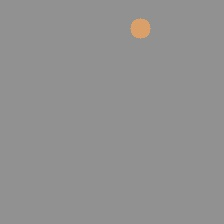

ic| img.shape: (224, 224, 3)
ic| output.shape: torch.Size([1, 4, 7, 7])
ic| ans: tensor([[[3, 3, 0, 2, 0, 0, 0],
                  [3, 3, 3, 2, 2, 0, 0],
                  [3, 3, 0, 2, 0, 0, 0],
                  [3, 3, 3, 2, 0, 0, 0],
                  [3, 3, 3, 3, 3, 3, 3],
                  [3, 3, 3, 3, 3, 3, 3],
                  [3, 3, 3, 3, 3, 3, 3]]], device='cuda:0')
ic| sample['label_grid']: array([[3, 3, 3, 3, 0, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3],
                                 [3, 3, 3, 3, 3, 3, 3]])


array([[3, 3, 3, 3, 0, 3, 3],
       [3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3]])

In [21]:
#sample = next(iter(dataloaders['train']))
sample = test_ds[3]
img = sample['image']
ic(sample['label'])
imshow(img)
ic(img.shape)
input_ = torch.unsqueeze(data_transform(img), 0)
input_ = input_.to(device)
output = model(input_)
ic(output.shape)
ans = torch.argmax(output, 1)
ic(ans)
ic(sample['label_grid'])